Thanh Truc Bui

In [24]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import h5py
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay

load_dotenv() # load environment variables

abs_path_to_split30_fasta = os.getenv("FASTA_ENZYMES","not found")
abs_path_to_non_enzyme_fasta = os.getenv("FASTA_NON_ENZYMES","not found")


Python-dotenv could not parse statement starting at line 8


<font size="5">Read the protein mass table</font>

In [8]:

def read_mass_csv(path):  
    masses={}
    with open(path, "r") as file:
        for line in file:
            info = line.split("\t")
            char = info[0]
            mass = info[1]
            masses[char] = mass
    return masses

protein_masses=read_mass_csv(r'/home/trucbui/PBLGit/random_forest/mass.tsv')

def cal_mass(seq):
    mass = 0.0
    for char in seq:
        if char in protein_masses.keys():
            mass += float(protein_masses[char])
    mass = round(mass, 3)
    return mass


<font size="5">Create a protein class</font>

In [9]:

class Protein:
    def __init__(self, header, seq, is_enzyme):
        self.header = header
        self.seq=seq
        self.mass=cal_mass(seq)
        self.is_enzyme=is_enzyme
        self.embeddings=None
        self.emb_max=0.0
        self.emb_min=0.0
        self.emb_median=0.0
        self.emb_std=0.0
        self.emb_magnitude=0.0
        self.last_aa=seq[-1:]
        


<font size="5">Read data from fasta file</font>

In [10]:

def readfasta(fasta:str, is_enzyme:bool) -> dict: 
    seq_map=dict()
    enzyme=0
    if is_enzyme==True:
        enzyme=1
    with open(fasta, "r") as path:
        seq = ""
        header = path.readline().rstrip()[1:]
        for line in path.readlines():
            if line.startswith(">"):
                seq_map[header]=Protein(header,seq,enzyme)
                seq = ""
                header = line.rstrip()[1:]
            else:
                seq += line.rstrip()
        seq_map[header]=Protein(header,seq,enzyme)
    return seq_map

enzymes_map=readfasta(abs_path_to_split30_fasta,True)
non_enzymes_map=readfasta(abs_path_to_non_enzyme_fasta,False)


<font size="5">Read data from esm2 embeddings</font>

In [11]:
def magnitude(vector):
    return math.sqrt(sum(pow(element, 2) for element in vector))

In [12]:

def read_esm2(path_to_esm2:str,seq_map:dict) -> dict: 
    protein_map=seq_map
    with h5py.File(path_to_esm2) as hdf_handle:
        for header, emb in hdf_handle.items():
            if header in seq_map.keys():
                protein_map[header].embeddings = np.array(list(emb))
                protein_map[header].emb_max=np.max(protein_map[header].embeddings)
                protein_map[header].emb_min=np.min(protein_map[header].embeddings)
                protein_map[header].emb_median=np.median(protein_map[header].embeddings)                
                protein_map[header].emb_std=np.std(protein_map[header].embeddings)
                protein_map[header].emb_magnitude=magnitude(protein_map[header].embeddings)
    return protein_map


enzymes_map = read_esm2(os.getenv("ESM2_ENZYMES_SPLIT_30"),enzymes_map)
non_enzymes_map = read_esm2(os.getenv("ESM2_NON_ENZYMES"),non_enzymes_map)


<font size="5">Find out the most common last amino acid of the enzymes and non-enzymes set</font>

In [13]:
def most_common_last_aa(seq_map:dict):
    last_aa_list=dict()
    for header in seq_map.keys():
        last=seq_map[header].last_aa
        if not last in last_aa_list:
            last_aa_list[last] = 0
        last_aa_list[last]+=1
    common_aa=[]
    for aa in last_aa_list.keys():
        if not aa=="X":
            if (last_aa_list[aa]/len(seq_map))>0.09:
                common_aa.append(aa)
                print (last_aa_list[aa]/len(seq_map))
    return common_aa

enzymes_common_last_aa=most_common_last_aa(enzymes_map)
print(enzymes_common_last_aa)
non_enzymes_common_last_aa=most_common_last_aa(non_enzymes_map)
print(non_enzymes_common_last_aa)


0.09245980008691873
0.09104737070838766
0.09821816601477619
['K', 'S', 'L']
0.09470406561693079
0.09338767657333806
['K', 'L']


The most common last amino acids are not significant and thus will be ignored

<font size="5">Create a dataframe<font>

In [14]:
def making_df(seq_map:dict)->pd.DataFrame:
    headers=[]
    mass=[]
    labels=[]
    embs=[]
    emb_max_all=[]
    emb_min_all=[]
    emb_median_all=[]
    emb_std_all=[]
    emb_magnitude_all=[]
    
    for header in seq_map:
        headers.append(header)
        entry=seq_map[header]
        labels.append(entry.is_enzyme)
        mass.append(entry.mass)
        embs.append(entry.embeddings)
        emb_max_all.append(entry.emb_max)    
        emb_min_all.append(entry.emb_min)
        emb_median_all.append(entry.emb_median)     
        emb_std_all.append(entry.emb_std)
        emb_magnitude_all.append(entry.emb_magnitude)
    return pd.DataFrame(data={'Label':labels ,'Entry':headers,'Mass':mass, 'Emb max':emb_max_all, 'Emb min':emb_min_all,
'Emb median': emb_median_all, 'Emb std': emb_std_all, 'Emb magnitude': emb_magnitude_all})

enzymes_df=making_df(enzymes_map)
enzymes_df=enzymes_df.sort_values(['Entry'],ascending=[True])

non_enzymes_df=making_df(non_enzymes_map)
non_enzymes_df=non_enzymes_df.sort_values(['Entry'],ascending=[True])

df=pd.concat([enzymes_df,non_enzymes_df],axis=0)
df=df.reset_index(drop=True)
print(df)




       Label       Entry        Mass    Emb max   Emb min  Emb median  \
0          1  A0A024RBG1   20403.292  12.089359 -0.613488   -0.003883   
1          1  A0A024SMV2   42741.490  10.992490 -0.462509   -0.002613   
2          1  A0A060S684   63631.543  11.732064 -0.775824   -0.002250   
3          1  A0A075TXZ3   61430.846  11.502498 -0.975507   -0.001353   
4          1  A0A077K8G3   45202.778  12.043853 -0.965225   -0.004369   
...      ...         ...         ...        ...       ...         ...   
48701      0      X2JAU8  117164.590   9.954324 -1.101609   -0.003210   
48702      0      X5HYT8   46670.171  13.143876 -0.896627   -0.003682   
48703      0      X5LX76  118226.070  12.641706 -0.686069   -0.003806   
48704      0      X6R8D5   14504.182  13.531825 -1.542869   -0.004650   
48705      0      X6R8R1   52161.639   9.344967 -0.876774   -0.001748   

        Emb std  Emb magnitude  
0      0.246559      12.475115  
1      0.224955      11.381984  
2      0.238975      12.

<font size="5">Train the model</font>

In [15]:
#Define the features and output:
y = np.array(df['Label'])
X = df.drop(['Label','Entry'],axis=1)
#Split data into train an test, with test size of 20%:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
#Build the model:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred=rf.predict(X)

<font size="5">Evaluate the model</font>

accuracy on training set: 0.999897
accuracy on test set: 0.826422
F1 score: 0.9039170115072843
MCC score: 0.8839634550217117


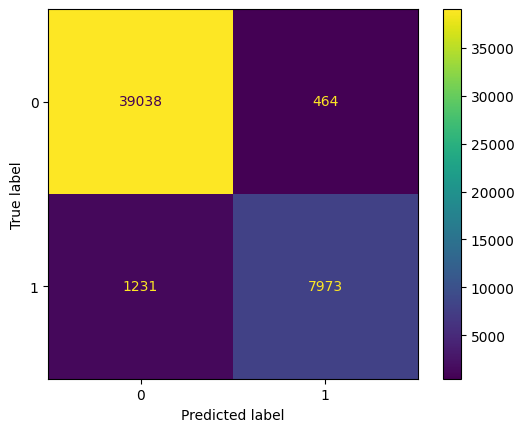

In [26]:
cm=confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
print("accuracy on training set: %f" % rf.score(X_train, y_train))
print("accuracy on test set: %f" % rf.score(X_test, y_test))
f1 = f1_score(y, y_pred, zero_division="warn")
print('F1 score:', f1)
mcc_score=matthews_corrcoef(y, y_pred)
print('MCC score:', mcc_score)


<font size="5">Make a tree</font>

In [17]:
#Using only 5 nodes:
rf_5 = RandomForestClassifier(max_depth=5)
rf_5.fit(X_train, y_train)
# Pull out one tree from the forest:
tree = rf_5.estimators_[5]
# Export the image to a dot file:
export_graphviz(tree, out_file = 'tree.dot', feature_names = X.columns, rounded = True, precision = 1)
# Use dot file to create a graph:
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file:
graph.write_png('tree_rf.png')

In [18]:
df.to_csv(r'/home/trucbui/PBLGit/random_forest/dataframe')  